# Idea & Hypothesis

- **Hypothesis**:`CpGs with high perturbation == more signal / information`
	- More weight = more perturbation = more relevant to AE reconstruction = important CpGs capturing signal (GWAS analogy: SNPs vs Imputed area)

--> More often in EWAS than CpGs with no perturbation (trait specific, trait agnostic)
--> Better reconstruction accuracy
--> Predictive for phenotype

In [1]:
import pandas as pd
import numpy as np
import pickle 
import torch
from data.prepareData import prepareDataLoader_fromPkl
import seaborn as sns
import os
import matplotlib.pyplot as plt

import random
import copy

from scipy.stats import mannwhitneyu

sns.set_theme(style="ticks", font_scale=1.8)

c_high = sns.color_palette("Blues")[5]
c_low = sns.color_palette("Blues")[3]
c_none = sns.color_palette("Blues")[1]

In [2]:
'''
Merge highly connected CpGs of all chromosomes
'''
all_cpgs_high = []
all_cpgs_low = []
all_cpgs_none = []

for CHR in [f"chr{i}" for i in range(1,23)]:
    print(CHR)
    PATH_data = "/data/scratch/skatz/PROJECTS/methylnet/1_healthyVAE/data/GSE87571/train_val_test_sets/"
    PATH_model= f"logs/finalModels/{CHR}"
    PATH_perturbation = f"results/{CHR}/perturbations"

    # Load beta matrix
    #with open(os.path.join(PATH_data, "chr22_wholeDataset.pkl"), "rb") as f: whole_dataset = pickle.load(f) #

    # Load CpG connections
    #conn = pd.read_csv(f"{PATH_perturbation}/quantileCutoff_CpGfocus.csv", index_col=0)
    with open(f"{PATH_perturbation}/global_connectivity_groups.pkl", "rb") as f: dic_globalConn = pickle.load(f)
    chr_idx_cpgs_high = dic_globalConn["global_high"]
    chr_idx_cpgs_low = dic_globalConn["global_low"]
    chr_idx_cpgs_none = dic_globalConn["global_none"]
    print(f"High CpGs: {len(chr_idx_cpgs_high)}\nLow CpGs: {len(chr_idx_cpgs_low)}\nNone CpGs: {len(chr_idx_cpgs_none)}\n")
    
    all_cpgs_high = all_cpgs_high + chr_idx_cpgs_high
    all_cpgs_low = all_cpgs_low + chr_idx_cpgs_low
    all_cpgs_none = all_cpgs_none + chr_idx_cpgs_none
    
print(f"\n\nAll Chromosomes - High CpGs: {len(all_cpgs_high)}\nAll Chromosomes - Low CpGs: {len(all_cpgs_low)}\nAll Chromosomes - None CpGs: {len(all_cpgs_none)}\n")

chr1
High CpGs: 2825
Low CpGs: 17104
None CpGs: 9553

chr2
High CpGs: 2247
Low CpGs: 12558
None CpGs: 7179

chr3
High CpGs: 1637
Low CpGs: 7250
None CpGs: 6660

chr4
High CpGs: 1291
Low CpGs: 6511
None CpGs: 5298

chr5
High CpGs: 1558
Low CpGs: 6773
None CpGs: 7634

chr6
High CpGs: 1869
Low CpGs: 11702
None CpGs: 9499

chr7
High CpGs: 1801
Low CpGs: 11772
None CpGs: 6026

chr8
High CpGs: 1742
Low CpGs: 8211
None CpGs: 3751

chr9
High CpGs: 724
Low CpGs: 3938
None CpGs: 1957

chr10
High CpGs: 1426
Low CpGs: 7797
None CpGs: 6513

chr11
High CpGs: 2045
Low CpGs: 10118
None CpGs: 6407

chr12
High CpGs: 1588
Low CpGs: 7374
None CpGs: 6203

chr13
High CpGs: 851
Low CpGs: 4739
None CpGs: 2212

chr14
High CpGs: 926
Low CpGs: 8059
None CpGs: 432

chr15
High CpGs: 1001
Low CpGs: 8263
None CpGs: 451

chr16
High CpGs: 1639
Low CpGs: 11763
None CpGs: 421

chr17
High CpGs: 2153
Low CpGs: 14488
None CpGs: 403

chr18
High CpGs: 355
Low CpGs: 1957
None CpGs: 1342

chr19
High CpGs: 1958
Low CpGs: 13056


# Check EWAS catalogue if more perturbed CpGs are more frequent

In [17]:
### Read in EWAS results from EWAS cataloge (all results!)
ewas = pd.read_table("../EWAScatalogue/ewascatalog-results.txt", low_memory=False)
studies = pd.read_table("../EWAScatalogue/ewascatalog-studies.txt")

## Phenotype: Age

In [18]:
### Only include studies carried out in Whole blood and measuring Age 
studies_filtered = studies[(studies["Tissue"] == "Whole blood") & (studies["Trait"].str.contains("age", case=False))]
ewas_studies = ewas[ewas["StudyID"].isin(studies_filtered["StudyID"])]

# ## Only consider Chr22
# ewas_studies = ewas_studies[ewas_studies["Chr"] == "22"]

print(f"Number of EWAS studies reported:\t{len(ewas_studies)}")
print(f"Number of CpGs reported:\t{len(ewas_studies['CpG'].unique().tolist())}")

Number of EWAS studies reported:	727651
Number of CpGs reported:	376231


In [19]:
## Parse highly perturbed CpGs and lowly perturbed CpGs from EWAS catalogue 
idx_cpgs_high_ewas = list(set(ewas_studies["CpG"]) & set(all_cpgs_high))
idx_cpgs_low_ewas = list(set(ewas_studies["CpG"]) & set(all_cpgs_low))
idx_cpgs_none_ewas = list(set(ewas_studies["CpG"]) & set(all_cpgs_none))

print(f"Highly perturbed CpGs\t total: {len(all_cpgs_high)} CpGs \t EWAS catalogue: {len(idx_cpgs_high_ewas)} CpGs\t Ratio: {round((len(idx_cpgs_high_ewas)/len(all_cpgs_high))*100,1)} %")
print(f"Lowly perturbed CpGs\t total: {len(all_cpgs_low)} CpGs \t EWAS catalogue: {len(idx_cpgs_low_ewas)} CpGs\t Ratio: {round((len(idx_cpgs_low_ewas)/len(all_cpgs_low))*100,1)} %")
print(f"Not perturbed CpGs\t total: {len(all_cpgs_none)} CpGs \t EWAS catalogue: {len(idx_cpgs_none_ewas)} CpGs\t Ratio: {round((len(idx_cpgs_none_ewas)/len(all_cpgs_none))*100,1)} %")

Highly perturbed CpGs	 total: 30949 CpGs 	 EWAS catalogue: 26844 CpGs	 Ratio: 86.7 %
Lowly perturbed CpGs	 total: 181798 CpGs 	 EWAS catalogue: 151628 CpGs	 Ratio: 83.4 %
Not perturbed CpGs	 total: 87253 CpGs 	 EWAS catalogue: 69187 CpGs	 Ratio: 79.3 %


In [20]:
import random 
import time 
t0 = time.time()

all_cpgs = all_cpgs_high + all_cpgs_low + all_cpgs_none
set_ewas = set(ewas_studies["CpG"])

success_high = []
success_low = []
success_none = []
for i in range(100):
    ### Randomly draw 557 CpGs from our prepcoessed dataset (total: 5243 CpGs), what are the odds of getting 91.6 %
    rand_high = random.sample(all_cpgs, len(all_cpgs_high))
    tmp = len(list(set(rand_high) & set_ewas))
    success_high.append(tmp/len(rand_high))

    ### Randomly draw 2266 CpGs from our prepcoessed dataset (total: 5243 CpGs), what are the odds of getting 84.2 %
    rand_low = random.sample(all_cpgs, len(all_cpgs_low))
    tmp = len(list(set(rand_low) & set_ewas))
    success_low.append(tmp/len(rand_low))    

    ### Randomly draw 2420 CpGs from our prepcoessed dataset (total: 5243 CpGs), what are the odds of getting 76.9 %
    rand_none = random.sample(all_cpgs, len(all_cpgs_none))
    tmp = len(list(set(rand_none) & set_ewas))
    success_none.append(tmp/len(rand_none))    

print(f"Seconds passed: {time.time()-t0}")

Seconds passed: 28.241807222366333


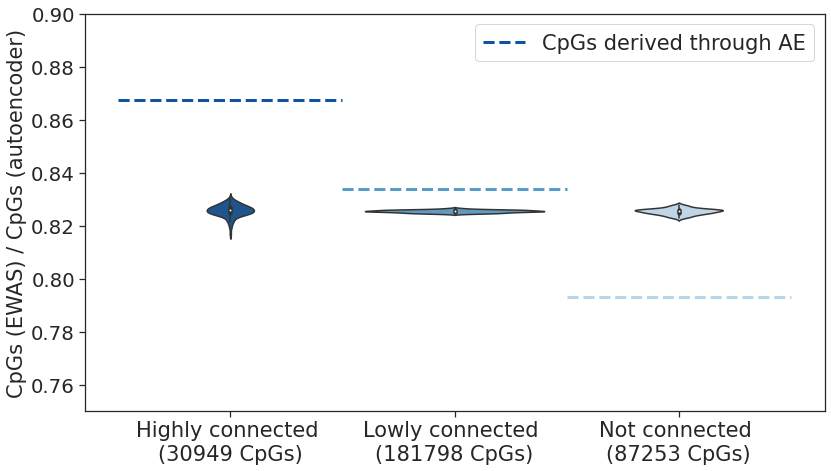

In [22]:
### Overlap between randomly drawn CpGs and EWAS-CpGs

fontsize=24

fig, ax = plt.subplots(1, 1, figsize=(12,7))
sns.violinplot(data=pd.DataFrame([success_high,success_low, success_none]).T, ax=ax, palette=[c_high, c_low, c_none])
ax.hlines(len(idx_cpgs_high_ewas)/len(all_cpgs_high), -.5, .5, linewidth=3, linestyles="dashed", color=c_high, label="CpGs derived through AE")
ax.hlines(len(idx_cpgs_low_ewas)/len(all_cpgs_low), .5, 1.5, linewidth=3, linestyles="dashed", color=c_low)
ax.hlines(len(idx_cpgs_none_ewas)/len(all_cpgs_none), 1.5, 2.5, linewidth=3, linestyles="dashed", color=c_none)
ax.set_ylim(0.75, 0.9)
ax.set_xticklabels([f"Highly connected \n({len(all_cpgs_high)} CpGs)",
                    f"Lowly connected \n({len(all_cpgs_low)} CpGs)",
                    f"Not connected \n({len(all_cpgs_none)} CpGs)"], fontsize=fontsize-3)
ax.set_ylabel("CpGs (EWAS) / CpGs (autoencoder)", fontsize=fontsize-3)
ax.legend(fontsize=fontsize-3)
plt.tight_layout()
plt.savefig(f"figures/global_connectivity_EWAS_age.png")

In [8]:
len(idx_cpgs_high_ewas)/len(all_cpgs_high)

0.8673624349736664

In [9]:
# fontsize=20

# fig, ax = plt.subplots(1, 1, figsize=(7,7))
# sns.violinplot(data=pd.DataFrame([success_high]).T, ax=ax, palette=[c_high])
# ax.hlines(len(idx_cpgs_high_ewas)/len(idx_cpgs_high), -.5, .5, linewidth=3, linestyles="dashed", color=c_high, label="Global CpGs")
# ax.set_ylim(0.7, 1)
# ax.set_xticklabels([f"Highly connected CpGs \n({len(idx_cpgs_high)} CpGs)"], fontsize=fontsize)
# ax.set_ylabel("CpGs (EWAS) / CpGs (autoencoder)", fontsize=fontsize)
# ax.legend(fontsize=fontsize)

# plt.tight_layout()
# plt.savefig(f"figures/global_connectivity_EWAS_highOnly.png")

## All phenotypes
- from whole blood

In [10]:
### Only include studies carried out in Whole blood and measuring Age 
studies_filtered = studies[(studies["Tissue"] == "Whole blood")]
ewas_studies = ewas[ewas["StudyID"].isin(studies_filtered["StudyID"])]

print(len(ewas_studies))
print(print(f"Number of CpGs reported:\t{len(ewas_studies['CpG'].unique().tolist())}"))

1364267
Number of CpGs reported:	487409
None


In [11]:
## Parse highly perturbed CpGs and lowly perturbed CpGs from EWAS catalogue 
idx_cpgs_high_ewas = list(set(ewas_studies["CpG"]) & set(all_cpgs_high))
idx_cpgs_low_ewas = list(set(ewas_studies["CpG"]) & set(all_cpgs_low))
idx_cpgs_none_ewas = list(set(ewas_studies["CpG"]) & set(all_cpgs_none))

print(f"Highly perturbed CpGs\t total: {len(all_cpgs_high)} CpGs \t EWAS catalogue: {len(idx_cpgs_high_ewas)} CpGs\t Ratio: {round((len(idx_cpgs_high_ewas)/len(all_cpgs_high))*100,1)} %")
print(f"Lowly perturbed CpGs\t total: {len(all_cpgs_low)} CpGs \t EWAS catalogue: {len(idx_cpgs_low_ewas)} CpGs\t Ratio: {round((len(idx_cpgs_low_ewas)/len(all_cpgs_low))*100,1)} %")
print(f"Not perturbed CpGs\t total: {len(all_cpgs_none)} CpGs \t EWAS catalogue: {len(idx_cpgs_none_ewas)} CpGs\t Ratio: {round((len(idx_cpgs_none_ewas)/len(all_cpgs_none))*100,1)} %")

Highly perturbed CpGs	 total: 30949 CpGs 	 EWAS catalogue: 29098 CpGs	 Ratio: 94.0 %
Lowly perturbed CpGs	 total: 181798 CpGs 	 EWAS catalogue: 166547 CpGs	 Ratio: 91.6 %
Not perturbed CpGs	 total: 87253 CpGs 	 EWAS catalogue: 76564 CpGs	 Ratio: 87.7 %


In [12]:
import random 
import time 
t0 = time.time()

all_cpgs = all_cpgs_high + all_cpgs_low + all_cpgs_none
set_ewas = set(ewas_studies["CpG"])

success_high = []
success_low = []
success_none = []
for i in range(100):
    ### Randomly draw 557 CpGs from our prepcoessed dataset (total: 5243 CpGs), what are the odds of getting 91.6 %
    rand_high = random.sample(all_cpgs, len(all_cpgs_high))
    tmp = len(list(set(rand_high) & set_ewas))
    success_high.append(tmp/len(rand_high))

    ### Randomly draw 2266 CpGs from our prepcoessed dataset (total: 5243 CpGs), what are the odds of getting 84.2 %
    rand_low = random.sample(all_cpgs, len(all_cpgs_low))
    tmp = len(list(set(rand_low) & set_ewas))
    success_low.append(tmp/len(rand_low))    

    ### Randomly draw 2420 CpGs from our prepcoessed dataset (total: 5243 CpGs), what are the odds of getting 76.9 %
    rand_none = random.sample(all_cpgs, len(all_cpgs_none))
    tmp = len(list(set(rand_none) & set_ewas))
    success_none.append(tmp/len(rand_none))    

print(f"Seconds passed: {time.time()-t0}")

Seconds passed: 29.964882135391235


In [13]:
# ### Overlap between randomly drawn CpGs and EWAS-CpGs

# fig, ax = plt.subplots(1, 1, figsize=(12,7))
# sns.violinplot(data=success_high, ax=ax, color="gold")
# ax.hlines(len(idx_cpgs_high_ewas)/len(all_cpgs_high), -.5, .5, linestyles="dashed", color="red", label="perturbed CpGs")
# ax.set_ylim(0.7, 1)
# ax.legend()
# ax.set_xlabel(f"CpGs w/ HIGH perturbation ({len(all_cpgs_high)} CpGs)")
# ax.set_xticklabels("")
# sns.violinplot(data=success_low, ax=ax2, color="gray")
# ax2.hlines(len(idx_cpgs_low_ewas)/len(all_cpgs_low), -.5, .5, linestyles="dashed", color="red")
# ax2.set_ylim(0.7, 1)
# ax2.set_xlabel(f"CpGs w/ LOW perturbation ({len(all_cpgs_low)} CpGs)")
# ax2.set_xticklabels("")
# sns.violinplot(data=success_none, ax=ax3, color="teal")
# ax3.hlines(len(idx_cpgs_none_ewas)/len(all_cpgs_none), -.5, .5, linestyles="dashed", color="red")
# ax3.set_ylim(0.7, 1)
# ax3.set_xlabel(f"CpGs w/ NO perturbation ({len(all_cpgs_none)} CpGs)")
# ax3.set_xticklabels("")

# fig.suptitle("All phenotypes: CpGs with perturbation are reported more in EWAS (than randomly drawn CpGs)")
# ax.set_ylabel("CpGs in EWAS / CpGs in AE", fontsize=15)

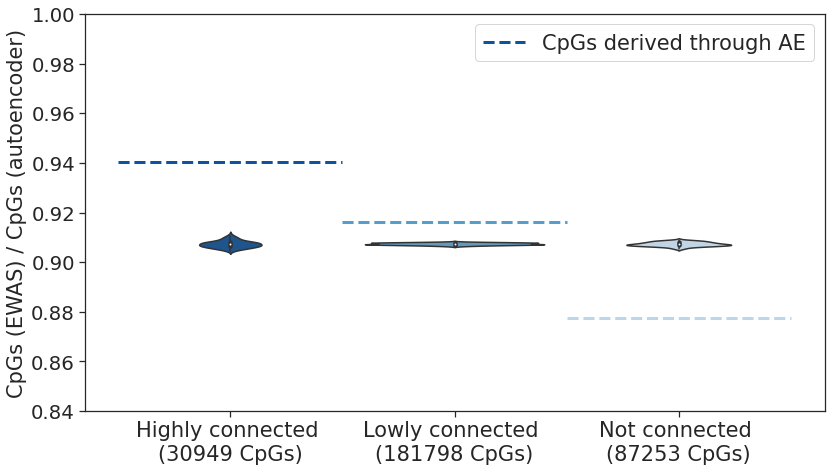

In [14]:
fig, ax = plt.subplots(1, 1, figsize=(12,7))
sns.violinplot(data=pd.DataFrame([success_high,success_low, success_none]).T, ax=ax, palette=[c_high, c_low, c_none])
ax.hlines(len(idx_cpgs_high_ewas)/len(all_cpgs_high), -.5, .5, linewidth=3, linestyles="dashed", color=c_high, label="CpGs derived through AE")
ax.hlines(len(idx_cpgs_low_ewas)/len(all_cpgs_low), .5, 1.5, linewidth=3, linestyles="dashed", color=c_low)
ax.hlines(len(idx_cpgs_none_ewas)/len(all_cpgs_none), 1.5, 2.5, linewidth=3, linestyles="dashed", color=c_none)
ax.set_ylim(0.84, 1)
ax.set_xticklabels([f"Highly connected \n({len(all_cpgs_high)} CpGs)",
                    f"Lowly connected \n({len(all_cpgs_low)} CpGs)",
                    f"Not connected \n({len(all_cpgs_none)} CpGs)"], fontsize=fontsize-3)
ax.set_ylabel("CpGs (EWAS) / CpGs (autoencoder)", fontsize=fontsize-3)
ax.legend(fontsize=fontsize-3)
plt.tight_layout()
plt.savefig(f"figures/global_connectivity_EWAS_allPheno.png")